# imports 

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Callable, Dict

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.shared import roi
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
from shared.enums import DatasetType, EvaluationLevel

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas
import pandas as pd
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/')
PATH_DNET = PATH/'DNETs'
PATH_DNET_WSIS = PATH_DNET/'wsis'
PATH_GANGLIOGLIOMA = PATH/'Ganglioglioma'


seed = 42
np.random.seed(seed)

# data

## wsi and json paths

In [3]:
wsi_paths_dnets = fastai.data.transforms.get_files(path=PATH_DNET_WSIS, extensions=['.ndpi'])
wsi_paths_ganglioglioma = fastai.data.transforms.get_files(path=PATH_GANGLIOGLIOMA, extensions=['.ndpi'])
wsi_paths = list(wsi_paths_dnets+wsi_paths_ganglioglioma)

json_paths_dnets = fastai.data.transforms.get_files(path=PATH_DNET, extensions=['.json'])
json_paths_ganglioglioma = fastai.data.transforms.get_files(path=PATH_GANGLIOGLIOMA, extensions=['.json'])
json_paths = list(json_paths_dnets+json_paths_ganglioglioma)

In [4]:
print(len(wsi_paths_dnets))
print(len(json_paths_dnets))
print(len(wsi_paths_ganglioglioma))
print(len(json_paths_ganglioglioma))

55
52
176
167


## wsi path to json file mapping and roi creation

In [5]:
def get_json_path_for_wsi(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])->pathlib.Path:
    """
    Arguments:
        wsi_path: path to whole-slide image
        json_paths: a list of paths to all json files, which contain the coordinates of region of interests of the
                    corresponding wsi
    Returns:
        Returns path of corresponding json file or raises FileNotFoundError, if json file cannot be found in json_paths
    """
    wsi_name = wsi_path.stem
    for jp in json_paths:
        if(wsi_name == jp.stem):
            return jp
    
    raise FileNotFoundError(f'json file could not be found for {wsi_path}')

        
def get_rois_from_wsi_path(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])\
                            ->List[wsi_processing_pipeline.shared.roi.RegionOfInterestPolygon]:
    json_path = get_json_path_for_wsi(wsi_path=wsi_path, json_paths=json_paths)
    return roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path)

In [6]:
wsi_paths_all_without_corresponding_json_file = []
wsi_path_to_json_path = {}

for wp in wsi_paths:
    try:
        json_path = get_json_path_for_wsi(wsi_path=wp, json_paths=json_paths)
        wsi_path_to_json_path[wp] = json_path
        
        #if(json_path in duplicates):
        #if(json_path in jps):
        #    print(wp)
        #jps.append(json_path)
    except FileNotFoundError:
        wsi_paths_all_without_corresponding_json_file.append(wp)

In [7]:
wsi_paths_all_without_corresponding_json_file

[Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1365-13-I2.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1825-18-I13.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1684 18-I8.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1825-18-I7.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N164-19-5.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N402-16.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N829-17-IV2.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N1531-15-II3.1.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N1531-15-II6.ndpi'),
 Path('/home/Deep_Learner/p

In [8]:
wsi_paths_with_json_files = list(wsi_path_to_json_path.keys())

In [9]:
wsi_path_to_rois = {}
for wp in wsi_paths_with_json_files:
    wsi_path_to_rois[wp] = get_rois_from_wsi_path(wsi_path=wp, json_paths=json_paths)

## id and label funcs

In [10]:
# one case per patient => patient id == case id
def get_patient_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return get_case_id_from_wsi_path(wsi_path=wsi_path)
    
def get_case_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    if('casus' in str(wsi_path.stem)):
        return wsi_path.stem
    split = wsi_path.stem.split('-')
    return f'{split[0]}-{split[1]}'    

def get_slide_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return wsi_path.stem

def get_labels_from_wsi_path(wsi_path:pathlib.Path, roi=None)->List[int]:
    if('Ganglioglioma' in str(wsi_path.parent)):
        return ['Ganglioglioma']
    if('DNETs' in str(wsi_path)):
        return ['DNET']
    raise AssertionError(f'No label could be determinated for {wsi_path}')

## tiles

In [18]:
wsi_paths_dnets_with_json_files = []
wsi_paths_ggs_with_json_files = []
for p in list(wsi_path_to_json_path.keys()):
    if(p.parent.parent.name == 'DNETs'):
        wsi_paths_dnets_with_json_files.append(p)
    elif(p.parent.parent.name == 'Ganglioglioma'):
        wsi_paths_ggs_with_json_files.append(p)
    else:
        assert False

In [19]:
len(wsi_path_to_json_path.keys()) == len(wsi_paths_dnets_with_json_files)+len(wsi_paths_ggs_with_json_files)

True

In [22]:
tilesummaries_dnets = tiles.WsisToTilesParallel(wsi_paths=wsi_paths_dnets_with_json_files,
                                                shifted_grid=True,
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          minimal_acceptable_tile_height=0.7, 
                                          minimal_acceptable_tile_width=0.7,
                                          tile_scoring_function=tiles.scoring_function_2,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois ,
                                          minimal_tile_roi_intersection_ratio=0.9, 
                                          verbose=False)


  0%|          | 0/51 [00:00<?, ?it/s]

Can't validate JPEG for directory 0: Expected marker at 4294975591, found none



 27%|██▋       | 14/51 [00:48<01:40,  2.72s/it]

Can't validate JPEG for directory 0: Expected marker at 4294976039, found none



 96%|█████████▌| 49/51 [03:45<00:21, 10.69s/it]

In [23]:
tilesummaries_ggs = tiles.WsisToTilesParallel(wsi_paths=wsi_paths_ggs_with_json_files,
                                              shifted_grid=False,
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          minimal_acceptable_tile_height=0.7, 
                                          minimal_acceptable_tile_width=0.7,
                                          tile_scoring_function=tiles.scoring_function_2,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois ,
                                          minimal_tile_roi_intersection_ratio=0.9, 
                                          verbose=False)



  0%|          | 0/167 [00:00<?, ?it/s]

Can't validate JPEG for directory 0: Expected marker at 4294974338, found none
Can't validate JPEG for directory 0: Expected marker at 4294972560, found none




  1%|          | 1/167 [00:07<19:45,  7.14s/it]

  1%|          | 2/167 [00:07<14:18,  5.20s/it]

  2%|▏         | 3/167 [00:08<10:29,  3.84s/it]

  2%|▏         | 4/167 [00:08<07:28,  2.75s/it]

  3%|▎         | 5/167 [00:09<05:54,  2.19s/it]

  4%|▎         | 6/167 [00:10<04:31,  1.68s/it]

  4%|▍         | 7/167 [00:10<03:24,  1.28s/it]

  5%|▍         | 8/167 [00:10<02:42,  1.02s/it]

  6%|▌         | 10/167 [00:11<02:14,  1.17it/s]

  7%|▋         | 11/167 [00:12<02:09,  1.20it/s]

  7%|▋         | 12/167 [00:13<02:15,  1.15it/s]

  8%|▊         | 13/167 [00:14<02:16,  1.13it/s]

Can't validate JPEG for directory 0: Expected marker at 4294970859, found none
Can't validate JPEG for directory 0: Expected marker at 4294970978, found none




  9%|▉         | 15/167 [00:14<01:46,  1.43it/s]

 10%|▉         | 16/167 [00:16<02:23,  1.05it/s]

 11%|█▏        | 19/167 [00:16<01:41,  1.46it/s]

Can't validate JPEG for directory 0: Expected marker at 4294970979, found none




 12%|█▏        | 20/167 [00:17<01:41,  1.45it/s]

 13%|█▎        | 21/167 [00:17<01:35,  1.52it/s]

 13%|█▎        | 22/167 [00:18<01:29,  1.63it/s]

 14%|█▍        | 24/167 [00:18<01:10,  2.04it/s]

 15%|█▍        | 25/167 [00:19<01:13,  1.94it/s]

 16%|█▌        | 27/167 [00:19<00:55,  2.51it/s]

 17%|█▋        | 28/167 [00:20<00:53,  2.61it/s]

 17%|█▋        | 29/167 [00:20<00:57,  2.42it/s]

 19%|█▊        | 31/167 [00:21<00:51,  2.64it/s]

 19%|█▉        | 32/167 [00:21<00:47,  2.86it/s]

 20%|█▉        | 33/167 [00:22<01:07,  1.97it/s]

 20%|██        | 34/167 [00:22<00:54,  2.42it/s]

 21%|██        | 35/167 [00:22<00:57,  2.30it/s]

 22%|██▏       | 37/167 [00:23<00:49,  2.65it/s]

 23%|██▎       | 38/167 [00:23<00:42,  3.03it/s]

 24%|██▍       | 40/167 [00:24<00:46,  2.73it/s]

 25%|██▍       | 41/167 [00:24<00:41,  3.07it/s]

 25%|██▌       | 42/167 [00:24<00:34,  3.67it/s]

 26%|██▌       | 43/167 [00:25<00:50,  2.47it/s]

 26%|██▋       | 44/167 [00:26<00:47,  2.58it/s]

Can't validate JPEG for directory 0: Expected marker at 4294970798, found none
Can't validate JPEG for directory 0: Expected marker at 4294970878, found none
Can't validate JPEG for directory 0: Expected marker at 4294970918, found none




 30%|██▉       | 50/167 [00:26<00:25,  4.59it/s]

 31%|███       | 51/167 [00:28<01:04,  1.80it/s]

 31%|███       | 52/167 [00:28<00:50,  2.28it/s]

Can't validate JPEG for directory 0: Expected marker at 4294976126, found none
Can't validate JPEG for directory 0: Expected marker at 4294973902, found none




 32%|███▏      | 54/167 [00:29<00:50,  2.24it/s]

 33%|███▎      | 55/167 [00:29<00:53,  2.08it/s]

 34%|███▎      | 56/167 [00:30<00:45,  2.43it/s]

 34%|███▍      | 57/167 [00:30<00:40,  2.73it/s]

 36%|███▌      | 60/167 [00:30<00:33,  3.18it/s]

 37%|███▋      | 61/167 [00:31<00:51,  2.04it/s]

 37%|███▋      | 62/167 [00:31<00:39,  2.64it/s]

 38%|███▊      | 63/167 [00:32<00:38,  2.70it/s]

 38%|███▊      | 64/167 [00:32<00:33,  3.03it/s]TopologyException: Input geom 0 is invalid: Self-intersection at or near point 89612.963333591149 37976.510000000002 at 89612.963333591149 37976.510000000002


The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fee8ee51bd0>




 39%|███▉      | 65/167 [00:33<00:48,  2.09it/s]

 40%|███▉      | 66/167 [00:34<00:53,  1.90it/s]

 40%|████      | 67/167 [00:34<00:41,  2.39it/s]

 41%|████      | 68/167 [00:35<00:57,  1.71it/s]

 41%|████▏     | 69/167 [00:35<00:49,  1.99it/s]

 42%|████▏     | 70/167 [00:35<00:38,  2.54it/s]

 43%|████▎     | 71/167 [00:36<00:39,  2.46it/s]

 43%|████▎     | 72/167 [00:36<00:35,  2.68it/s]

 44%|████▎     | 73/167 [00:37<00:44,  2.09it/s]

 44%|████▍     | 74/167 [00:38<01:02,  1.48it/s]

 46%|████▌     | 77/167 [00:38<00:45,  1.99it/s]

 47%|████▋     | 78/167 [00:38<00:38,  2.31it/s]

 48%|████▊     | 80/167 [00:39<00:31,  2.80it/s]

 49%|████▊     | 81/167 [00:39<00:24,  3.46it/s]

 49%|████▉     | 82/167 [00:39<00:32,  2.58it/s]

 50%|████▉     | 83/167 [00:40<00:31,  2.68it/s]

 51%|█████     | 85/167 [00:40<00:24,  3.40it/s]

 51%|█████▏    | 86/167 [00:40<00:19,  4.19it/s]

 52%|█████▏    | 87/167 [00:43<01:26,  1.08s/it]

 53%|█████▎    | 88/167 [00:44<01:30,  1.14s/it]

Can't validate JPEG for directory 0: Expected marker at 4294974266, found none
Can't validate JPEG for directory 0: Expected marker at 4294971043, found none
Can't validate JPEG for directory 0: Expected marker at 4294970639, found none




 56%|█████▋    | 94/167 [00:46<00:52,  1.40it/s]

Can't validate JPEG for directory 0: Expected marker at 4294976170, found none




 57%|█████▋    | 95/167 [00:46<00:45,  1.57it/s]

 57%|█████▋    | 96/167 [00:46<00:39,  1.80it/s]

 58%|█████▊    | 97/167 [00:47<00:34,  2.01it/s]

 59%|█████▊    | 98/167 [00:48<00:42,  1.62it/s]

 59%|█████▉    | 99/167 [00:48<00:37,  1.79it/s]

 60%|██████    | 101/167 [00:49<00:32,  2.03it/s]

 61%|██████    | 102/167 [00:49<00:37,  1.73it/s]

 62%|██████▏   | 104/167 [00:50<00:31,  1.98it/s]

 63%|██████▎   | 105/167 [00:51<00:30,  2.01it/s]

 63%|██████▎   | 106/167 [00:51<00:24,  2.47it/s]

 65%|██████▍   | 108/167 [00:51<00:18,  3.12it/s]

 65%|██████▌   | 109/167 [00:51<00:14,  3.91it/s]

 66%|██████▌   | 110/167 [00:51<00:14,  3.88it/s]

 66%|██████▋   | 111/167 [00:52<00:18,  3.01it/s]

 67%|██████▋   | 112/167 [00:52<00:20,  2.63it/s]

 68%|██████▊   | 113/167 [00:53<00:18,  2.89it/s]

 68%|██████▊   | 114/167 [00:53<00:17,  3.10it/s]

 70%|███████   | 117/167 [00:54<00:17,  2.81it/s]

 71%|███████▏  | 119/167 [00:55<00:15,  3.06it/s]

 72%|███████▏  | 120/167 [00:55<00

In [25]:
tilesummaries = tilesummaries_dnets+tilesummaries_ggs

/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/N460-15-II.ndpi


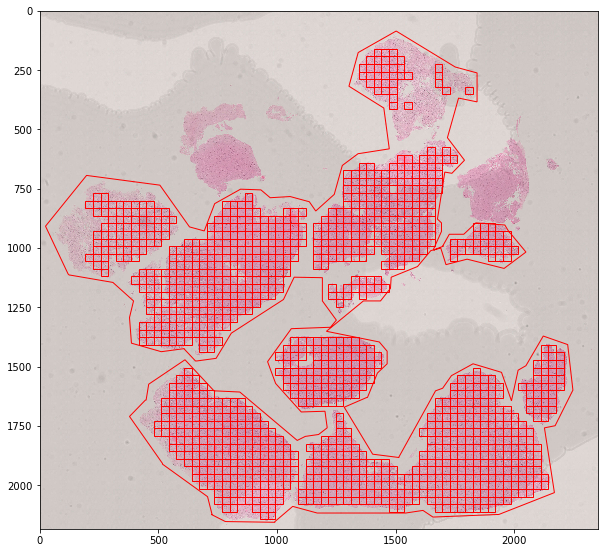

/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/N2024-16.ndpi


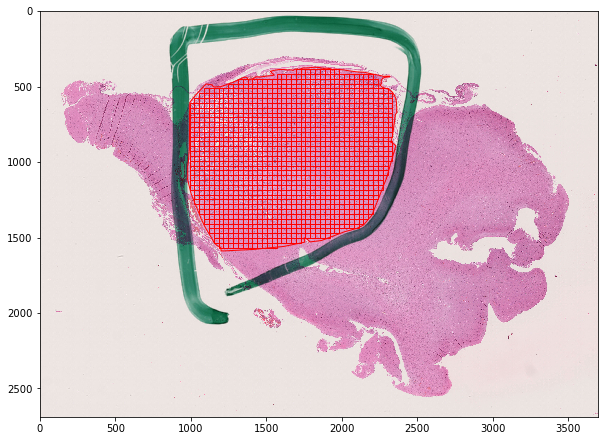

/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/N118-03-II1.ndpi


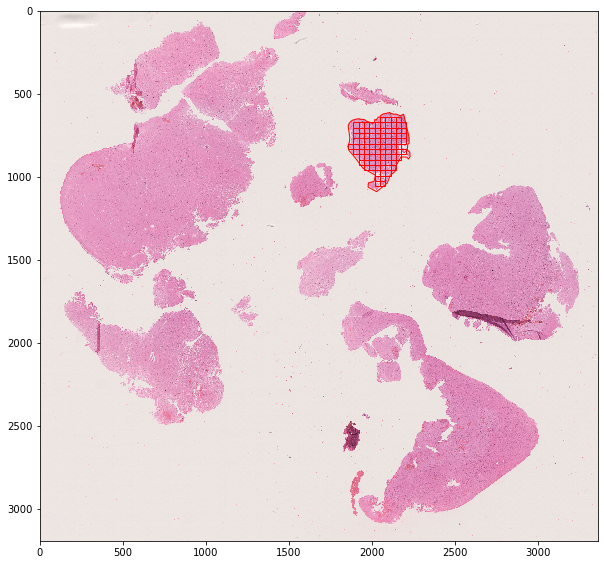

/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/N489-13-II2.ndpi


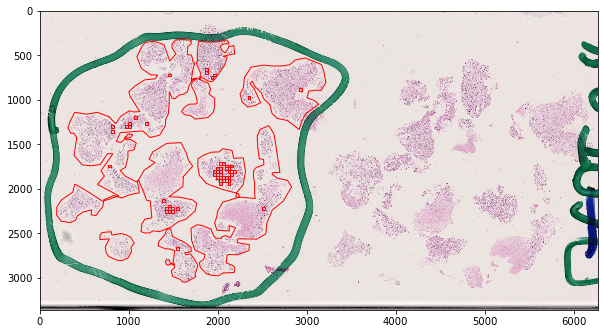

/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/N769-08-II.ndpi


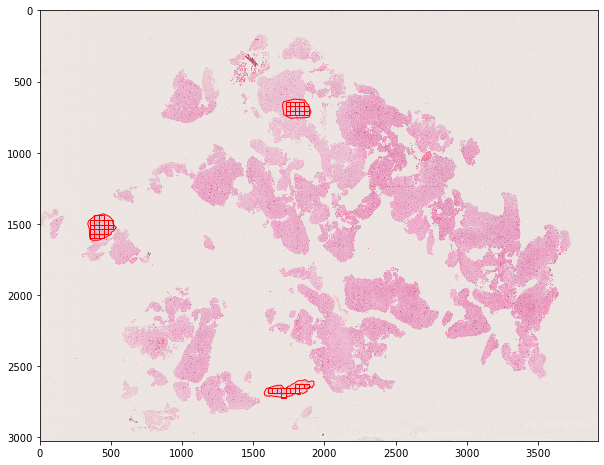

/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/N407-07-1.ndpi


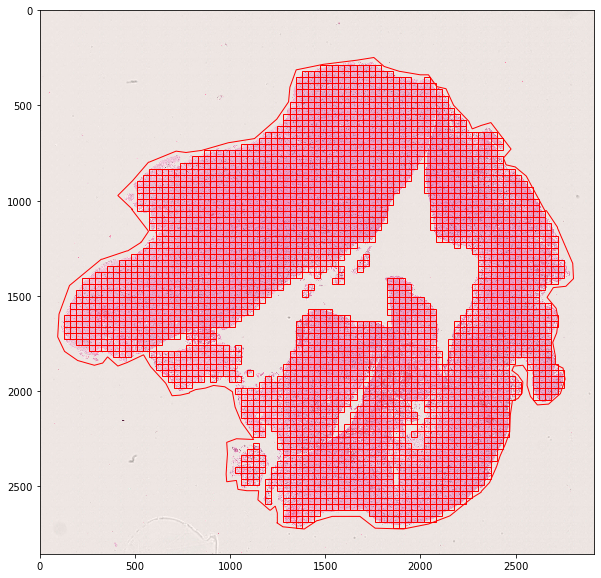

/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/N30-13.ndpi


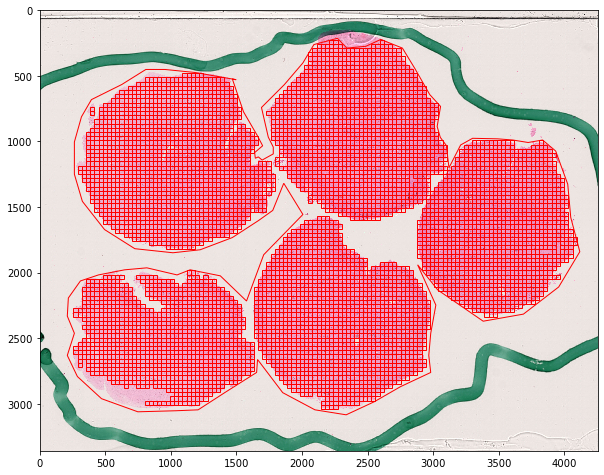

/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/N1944-18-IVB.ndpi


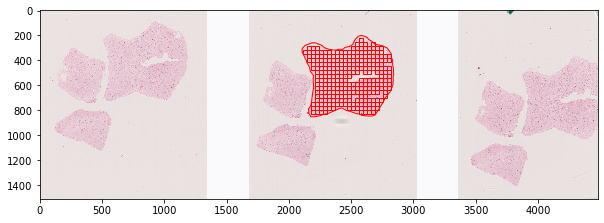

/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/casus26.ndpi


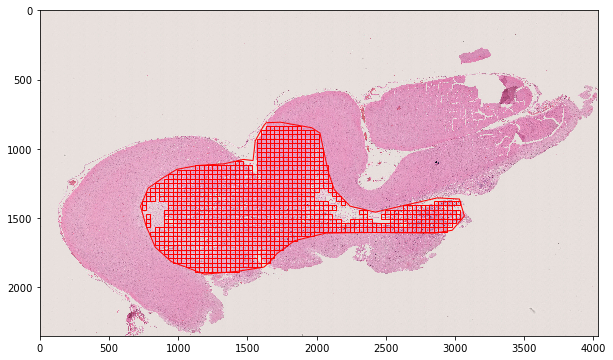

/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/N2-16-II2.ndpi


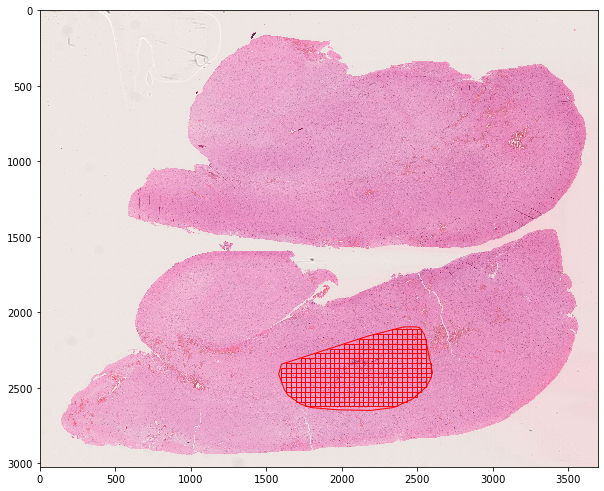

In [27]:
for ts in random.sample(tilesummaries, 10):
    print(ts.wsi_path)
    ts.show_wsi_with_top_tiles()

## patient manager 

In [35]:
patient_manager = PatientManager()

In [36]:
patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_patient_id_from_wsi_path, 
                                          case_id_getter=get_case_id_from_wsi_path, 
                                          slide_id_getter=get_slide_id_from_wsi_path, 
                                          labels_getter=get_labels_from_wsi_path)




  0%|          | 0/201 [00:00<?, ?it/s]


  6%|▋         | 13/201 [00:00<00:01, 121.17it/s]


  8%|▊         | 17/201 [00:00<00:03, 56.38it/s] 


 10%|█         | 21/201 [00:00<00:05, 32.07it/s]


 12%|█▏        | 24/201 [00:00<00:10, 17.60it/s]


 13%|█▎        | 27/201 [00:01<00:10, 16.03it/s]


 15%|█▌        | 31/201 [00:01<00:09, 18.47it/s]


 17%|█▋        | 34/201 [00:01<00:14, 11.80it/s]


 18%|█▊        | 36/201 [00:02<00:18,  9.08it/s]


 19%|█▉        | 38/201 [00:02<00:26,  6.12it/s]


 20%|█▉        | 40/201 [00:02<00:22,  7.03it/s]


 21%|██        | 42/201 [00:03<00:22,  7.17it/s]


 22%|██▏       | 44/201 [00:03<00:22,  6.89it/s]


 22%|██▏       | 45/201 [00:03<00:26,  5.85it/s]


 23%|██▎       | 47/201 [00:03<00:24,  6.17it/s]


 24%|██▍       | 48/201 [00:04<00:28,  5.41it/s]


 24%|██▍       | 49/201 [00:04<00:30,  4.97it/s]


 35%|███▌      | 71/201 [00:04<00:18,  7.04it/s]


 45%|████▍     | 90/201 [00:04<00:11,  9.89it/s]


 50%|█████     | 101/201 [00:04<00:

In [37]:
train_size = 0.85
validation_size = 0.15
test_size = 0.0

patient_manager.split(train_size=train_size, validation_size=validation_size, test_size=test_size, random_state=seed)

In [38]:
class_distribution_all_tiles = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)

In [39]:
class_distribution_all_tiles

(413380,
 {'DNET': 241866, 'Ganglioglioma': 171514},
 {'DNET': 0.5850936184624317, 'Ganglioglioma': 0.4149063815375683})

In [40]:
class_distribution_all_cases = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.case, 
                                                            dataset_type=shared.enums.DatasetType.all)

In [41]:
class_distribution_all_cases

(128,
 {'DNET': 24, 'Ganglioglioma': 104},
 {'DNET': 0.1875, 'Ganglioglioma': 0.8125})

In [42]:
class_distribution_train = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.train)

In [43]:
class_distribution_train

(366521,
 {'DNET': 224053, 'Ganglioglioma': 142468},
 {'DNET': 0.6112964877865116, 'Ganglioglioma': 0.3887035122134884})

In [44]:
class_distribution_valid = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.validation)

In [45]:
class_distribution_valid

(46859,
 {'DNET': 17813, 'Ganglioglioma': 29046},
 {'DNET': 0.3801404212637914, 'Ganglioglioma': 0.6198595787362087})

## data block api

In [46]:
final_size = 512
bs = 35

data = fastai.data.block.DataBlock(
        blocks=(TileImageBlock, fastai.data.block.MultiCategoryBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.get_labels(),
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms=fastai.vision.augment.Resize(size=final_size, method = 'squish'),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

dls = data.dataloaders(patient_manager.get_tiles(dataset_type=DatasetType.train)\
                        +patient_manager.get_tiles(dataset_type=DatasetType.validation), 
                       bs=bs, 
                       verbose=False)

In [47]:
len(patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.train))

366521

In [48]:
len(dls.train_ds)

366521

In [49]:
len(patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation))

46859

In [50]:
len(dls.valid_ds)

46859

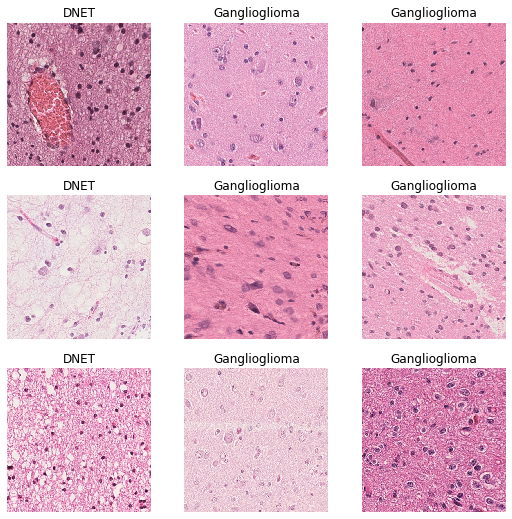

In [51]:
dls.show_batch()

# learner

## n

In [52]:
n=2

## create

In [53]:
#arch = torchvision.models.resnet.resnext101_32x8d
arch = torchvision.models.resnet50

In [54]:
learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai.metrics.accuracy_multi],
                     pretrained=True,
                     path=PATH/'models'/f'{n}-{arch.__name__}')

In [55]:
learner.to_fp16()

In [56]:
learner.path

Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/models/2-resnet50')

In [57]:
learner.path.parent.mkdir(exist_ok=True)

In [58]:
learner.path.mkdir(exist_ok=True)

## name

In [59]:
epochs_frozen = 5
epochs_unfrozen = 10

In [60]:
nameBase = f'{n}-{arch.__name__}'
nameBase

'2-resnet50'

## train

In [ ]:
learner.lr_find(start_lr=1e-15, end_lr=10, num_it=200)

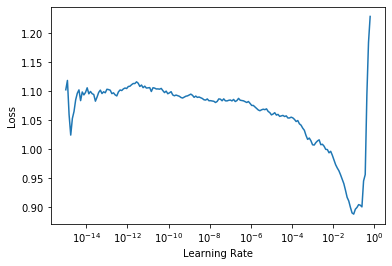

In [41]:
learner.recorder.plot_lr_find()

In [61]:
lr1 = 1e-2

In [62]:
log_head_name = 'log-head.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_frozen, 
                      lr_max=lr1, 
                      cbs=[CSVLogger(fname=log_head_name, append=True), SaveModelCallback(every_epoch=True, fname='head')])

In [ ]:
pd.read_csv(learner.path/log_head_name)

In [ ]:
nameHead = f'{nameBase}-head';nameHead

In [ ]:
learner.save(nameHead)

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find(start_lr=1e-11, end_lr=1e-2, num_it=500)

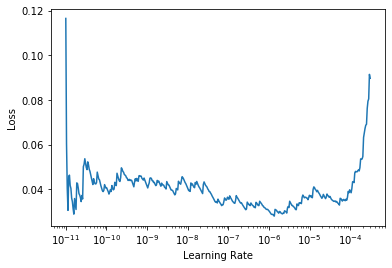

In [55]:
learner.recorder.plot_lr_find()

In [ ]:
lr2 = 1e-8
lr3 = 1e-7
lr4 = 1e-6

In [ ]:
log_complete_name = 'log-complete.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_unfrozen, 
                      lr_max=[lr2, lr3, lr4], 
                      cbs=[CSVLogger(fname=log_complete_name, append=True), SaveModelCallback(every_epoch=True, fname='complete')])

In [ ]:
pd.read_csv(learner.path/log_complete_name)

In [ ]:
nameComplete = f'{nameBase}-complete'; nameComplete

In [ ]:
learner.save(nameComplete)
#learner.load(nameComplete)

# prediction

In [36]:
from postprocessing.predictor import Predictor

In [37]:
predictor = Predictor(learner=learner, patient_manager=patient_manager)

In [38]:
from preprocessing import tile_image_block

In [39]:
predictor.predict_on_tiles(prediction_type=shared.enums.PredictionType.tiles_on_the_fly, 
                          dataset_type=shared.enums.DatasetType.validation,
                          tile_size=final_size, batch_size=bs)

In [40]:
thresholds = {'DNET':0.5, 'Ganglioglioma':0.5}
predictor.calculate_predictions_up_to_case_level(dataset_type=shared.enums.DatasetType.validation,
                                                thresholds = thresholds)

../wsi_processing_pipeline/postprocessing/predictor.py:233: RuntimeWarning: invalid value encountered in true_divide
  preds_raw = summed_up_raw_preds/tile_count
../wsi_processing_pipeline/postprocessing/predictor.py:234: RuntimeWarning: invalid value encountered in greater_equal
  preds_thresh = preds_raw >= np.array(list(thresholds.values()))


# evaluation

In [52]:
from postprocessing.evaluator import Evaluator
evaluator = Evaluator(predictor=predictor)

In [53]:
evaluator.calculate_accuracy_per_class(dataset_type=shared.enums.DatasetType.validation, 
                                       level=shared.enums.EvaluationLevel.case)


100%|██████████| 21/21 [00:00<00:00, 538.81it/s]


{'DNET': 0.7894736842105263, 'Ganglioglioma': 0.7894736842105263}

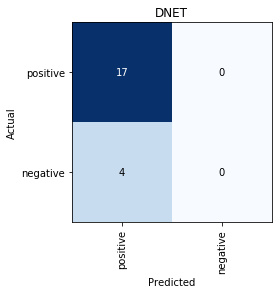

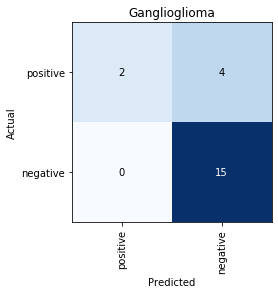

In [74]:
evaluator.plot_confusion_matrix(dataset_type=shared.enums.DatasetType.validation, 
                                level=shared.enums.EvaluationLevel.case)


  0%|          | 0/2 [00:00<?, ?it/s]

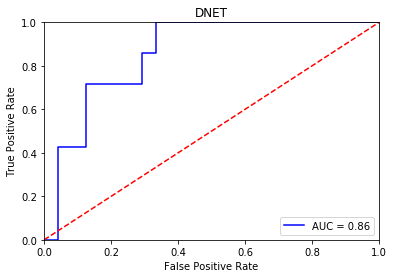


 50%|█████     | 1/2 [00:00<00:00,  7.33it/s]

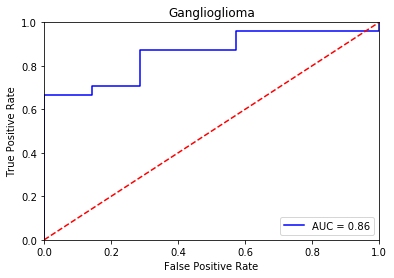


100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


In [76]:
evaluator.plot_roc_curves(dataset_type=shared.enums.DatasetType.validation, level=shared.enums.EvaluationLevel.slide)